In [72]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import chi2

In [ ]:
tickers = ['NVDA', 'GC=F', 'AAPL', 'COS', ] 
weights = np.array([0.3, 0.4, 0.3]) 

period = '1y' 
conf_level = 0.05 

def get_data(tickers, period):
    data = yf.download(tickers, period=period)['Close']
    return data.interpolate(method='linear')


prices = get_data(tickers, period)
log_returns = np.log(prices / prices.shift(1)).dropna() # calculating log returns
portfolio_log_returns = log_returns.dot(weights)

while True:
    try:
        method = int(input("Select VaR method 1 = Historical, 2 = Parametric, 3 = Monte Carlo: "))
        if method in [1, 2, 3]:
            break
        else:
            print("Error: Insert a number between 1 and 3.")
            
    except ValueError:
        print("Error: Insert a correct number (1, 2, or 3).")

[*********************100%***********************]  3 of 3 completed


Historical Value at Risk

In [74]:
def historical_VaR(returns, confidence_level=0.05):
    VaR = np.percentile(returns, confidence_level*100)
    ES = returns[returns <= VaR].mean()
    df = pd.DataFrame({'Returns' : returns})
    df['Breach'] = df['Returns'] < VaR
    breaches = df[df['Breach'] == True]['Returns']

    return VaR, ES, breaches

Parametric Value at Risk

In [75]:
def parametric_VaR(returns, confidence_level=0.05):
    df, loc, scale = st.t.fit(returns)
    VaR = st.t.ppf(confidence_level, df=df, loc=loc, scale=scale)
    ES = returns[returns <= VaR].mean()
    df = pd.DataFrame({'Returns' : returns})
    df['Breach'] = df['Returns'] < VaR
    breaches = df[df['Breach'] == True]['Returns']

    return VaR, ES, breaches

Monte Carlo Value at Risk

In [76]:
def montecarlo_VaR(returns, confidence_level=0.05, n_sim=10_000):
    df, loc, scale = st.t.fit(returns)
    random_log_returns = st.t.rvs(df=df, loc=loc, scale=scale, size = n_sim)
    VaR = np.percentile(random_log_returns, confidence_level*100)
    ES = random_log_returns[random_log_returns <= VaR].mean()
    df = pd.DataFrame({'Returns' : returns})
    df['Breach'] = df['Returns'] < VaR
    breaches = df[df['Breach'] == True]['Returns']

    return VaR, ES, breaches

Output

In [77]:
if method == 1:
    VaR, ES, breaches = historical_VaR(portfolio_log_returns, conf_level)

    print(f'Historical VaR {conf_level*100}% = {VaR:.4f}')
    print(f'Historical Expected Shortfall (CVaR) {conf_level*100}% = {ES:.4f}')



elif method == 2:
    VaR, ES, breaches = parametric_VaR(portfolio_log_returns, conf_level)

    print(f'Parametric VaR {conf_level*100}% = {VaR:.4f}')
    print(f'Parametric Expected Shortfall (CVaR) {conf_level*100}% = {ES:.4f}')

    x = np.linspace(1.5*VaR, -1.5*VaR)
    df, loc, scale = st.t.fit(portfolio_log_returns)
    pdf = st.t.pdf(x, df=df, loc=loc, scale=scale)

    

elif method == 3:
    VaR, ES, breaches = montecarlo_VaR(portfolio_log_returns, conf_level)

    print(f'Monte Carlo VaR {conf_level*100}% = {VaR:.4f}')
    print(f'Monte Carlo Expected Shortfall (CVaR) {conf_level*100}% = {ES:.4f}')

    df, loc, scale = st.t.fit(portfolio_log_returns)
    random_log_returns = st.t.rvs(df=df, loc=loc, scale=scale, size = 1000)

Parametric VaR 5.0% = -0.0209
Parametric Expected Shortfall (CVaR) 5.0% = -0.0301


Plotting

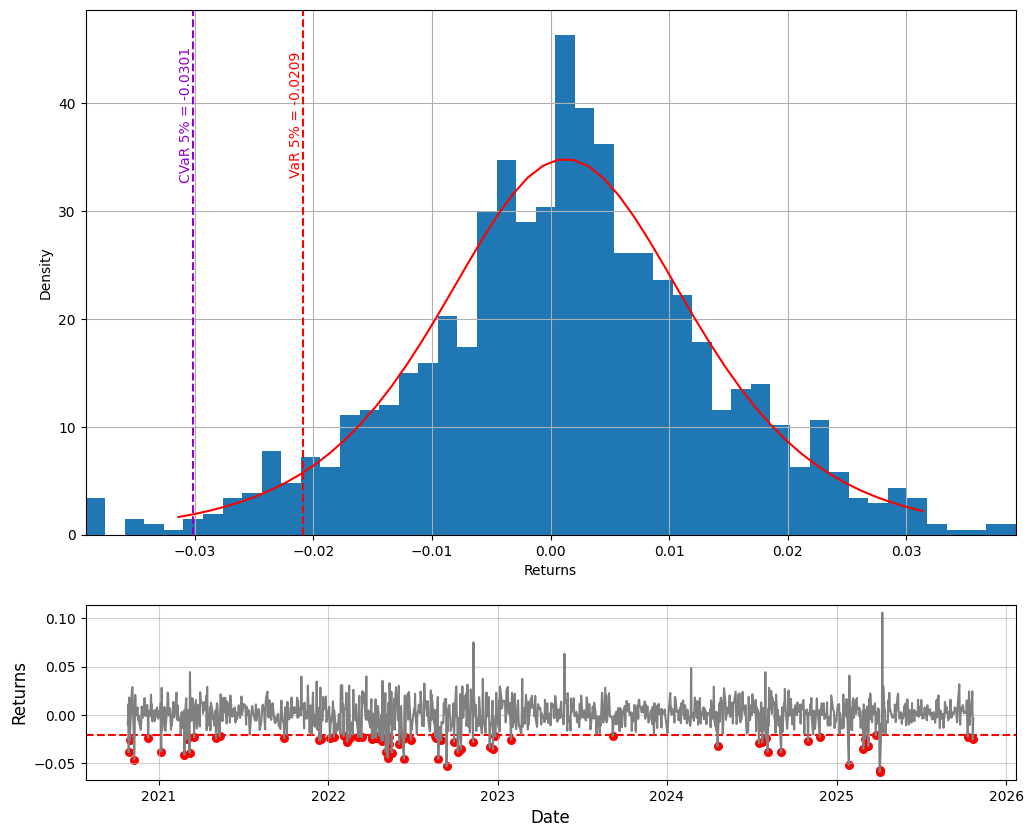

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]}) 

if method == 1:
    portfolio_log_returns.hist(bins=100, density=True, ax=ax[0])

elif method == 2:
    portfolio_log_returns.hist(bins=100, density=True, ax=ax[0])
    ax[0].plot(x, pdf, color='red')
    
elif method == 3:
    ax[0].hist(random_log_returns, bins=100, density=True)


ax[0].set_xlim(1.3*ES, -1.3*ES)
ax[0].axvline(VaR, color='red', linestyle='--', linewidth=1.5)
ax[0].text(VaR,
    ax[0].get_ylim()[1]*0.8,
    f'VaR {conf_level*100:.0f}% = {VaR:.4f}',
    color='red',
    rotation=90,
    va='center',
    ha='right')


ax[0].axvline(ES, color='darkviolet', linestyle='--', linewidth=1.5)
ax[0].text(ES,
    ax[0].get_ylim()[1]*0.8,
    f'CVaR {conf_level*100:.0f}% = {ES:.4f}',
    color='darkviolet',
    rotation=90,
    va='center',
    ha='right')
    

ax[1].axhline(VaR,
    color = 'red',
    linestyle='--',
    label = f'VaR {abs(VaR)*100:.1f}%')


ax[0].set_xlabel('Returns')
ax[0].set_ylabel('Density')


ax[1].plot(portfolio_log_returns, color = 'gray')
ax[1].scatter(breaches.index, breaches.values, color='red', marker='o', s=30, label = 'VaR Breaches')


ax[1].set_ylabel('Returns', fontsize=12)
ax[1].set_xlabel('Date', fontsize=12)
ax[1].grid(True, alpha=0.6)

plt.show()

Backtesting

Kupiec POF Test (POF - Proportion of Failures), Unconditional Coverage

In [79]:
def kupiec_test(returns, var, alpha=0.05):
    T = len(returns)
    x = np.sum(returns < var)
    pi = x/T

    log0 = x * np.log(alpha) + (T - x) * np.log(1 - alpha)
    log1 = x * np.log(pi) + (T - x) * np.log(1 - pi) if 0 < pi < 1 else -np.inf

    LR = -2 * (log0 - log1)
    p_value = 1 - st.chi2.cdf(LR, df=1)

    print(f'Number of violations: {x}')
    print(f'Kupiec\'s Statistic (LR): {LR:.4f}')
    print(f'p-value: {p_value:.4f}')

kupiec_test(portfolio_log_returns, VaR)

Number of violations: 71
Kupiec's Statistic (LR): 1.0834
p-value: 0.2979


Christoffersen Test, Conditional Coverage

In [80]:
def calculate_hits(actual, VaR_forecast):
    # converting T/F into 1/0
    hits = (actual < VaR_forecast) * 1
    return hits

In [81]:
def calculate_transition_counts(hits):
    N = len(hits)

    # tr = 1 if 0->1, tr = -1 if 1->0, tr = 0 if not changed
    tr = hits[1:] - hits[:-1]

    # sum n_ij
    n01 = np.sum(tr==1)
    n10  = np.sum(tr==-1)

    # No change
    hits_no_change = hits[1:][tr==0]
    n11 = np.sum(hits_no_change == 1) # 1 -> 1
    n00 = np.sum(hits_no_change == 0) # 0 -> 0

    n0 = n00 + n01 # Total days w/o violations
    n1 = n10 + n11 # Total days with violations

    return n00, n01, n10, n11, n0, n1, N

In [82]:
def calculate_hits(actual, VaR_forecast):
    # converting T/F into 1/0
    hits = (actual < VaR_forecast) * 1
    return hits

def calculate_transition_counts(hits):
    N = len(hits)

    # tr = 1 if 0->1, tr = -1 if 1->0, tr = 0 if not changed
    tr = hits[1:] - hits[:-1]

    # sum n_ij
    n01 = np.sum(tr==1)
    n10  = np.sum(tr==-1)

    # No change
    hits_no_change = hits[1:][tr==0]
    n11 = np.sum(hits_no_change == 1) # 1 -> 1
    n00 = np.sum(hits_no_change == 0) # 0 -> 0

    n0 = n00 + n01 # Total days w/o violations
    n1 = n10 + n11 # Total days with violations

    return n00, n01, n10, n11, n0, n1, N

def likelihood_func(prob_zero, count_zero, prob_one, count_one):
    """Calculates log-likelihood for a Bernoulli or Markov model (components)."""
    # Using np.log instead of log allows handling small values
    
    # Protection against logarithm of zero
    term1 = count_zero * np.log(prob_zero) if prob_zero > 0 else 0
    term2 = count_one * np.log(prob_one) if prob_one > 0 else 0

    return term1 + term2

def christoffersen_test(actual, VaR_forecast, alpha, alpha_test=0.05):
    
    hits = calculate_hits(actual, VaR_forecast)
    n00, n01, n10, n11, n0, n1, N = calculate_transition_counts(hits)
    
    if n1 == 0:
        # In case of no violations, Pi_hat1 estimators cannot be calculated
        # (division by n10+n11=0), independence and conditional tests are not diagnostic.
        return "No violations. LR_IND and LR_CC tests cannot be reliably calculated."
        
    # MLE for p_hat (H1_uc / H0_ind)
    p_hat = n1 / N

    # MLE for Pi_hat1 (H1_ind / H1_cc)
    pi01_hat = n01 / n0 if n0 > 0 else 0
    pi11_hat = n11 / n1 if n1 > 0 else 0

    # 1. Calculate Log-Likelihoods
    
    # L(p): H0_uc - Probability of violation = alpha (p)
    L_H0_uc = likelihood_func(1 - alpha, n0, alpha, n1)
    
    # L(Pi_hat): H1_uc (or H0_ind) - Probability of violation = p_hat
    L_H1_uc = likelihood_func(1 - p_hat, n0, p_hat, n1)
    
    # L(Pi_hat1): H1_ind/H1_cc - 1st order Markov Model
    # L(Pi_hat1) = L(0->0, 0->1) + L(1->0, 1->1)
    L_H1_cc = likelihood_func(1 - pi01_hat, n00, pi01_hat, n01) + \
                likelihood_func(1 - pi11_hat, n10, pi11_hat, n11)
                
    # 2. Calculate Test Statistics
    
    # Test Unconditional Coverage (LR_uc) - df=1
    LR_uc = -2 * (L_H0_uc - L_H1_uc)
    
    # Test Independence (LR_ind) - df=1
    LR_ind = -2 * (L_H1_uc - L_H1_cc)
    
    # Test Conditional Coverage (LR_cc) - df=2
    LR_cc = LR_uc + LR_ind
    
    # 3. Calculate p-value (using survival function chi2.sf = 1 - cdf)
    p_uc = chi2.sf(LR_uc, 1)
    p_ind = chi2.sf(LR_ind, 1)
    p_cc = chi2.sf(LR_cc, 2)
    
    # 4. Format and return results
    results = pd.DataFrame({
        'Test': ['Unconditional Coverage', 'Independence', 'Conditional Coverage'],
        'LR Statistic': [LR_uc, LR_ind, LR_cc],
        'P-Value': [p_uc, p_ind, p_cc],
        'Degrees of Freedom': [1, 1, 2],
        'Reject H0 (alpha=' + str(alpha_test) + ')': [p_uc < alpha_test, p_ind < alpha_test, p_cc < alpha_test]
    })
    
    return results.set_index('Test')

In [83]:
christoffersen_test(portfolio_log_returns, VaR, alpha=conf_level, alpha_test=0.05)

,LR Statistic,P-Value,Degrees of Freedom,Reject H0 (alpha=0.05)
Test,,,,
Unconditional Coverage,1.110988,2.918672e-01,1,False
Independence,545.642929,1.116444e-120,1,True
Conditional Coverage,546.753917,1.878864e-119,2,True
